<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-данных-из-файла-и-предобработка" data-toc-modified-id="Изучение-данных-из-файла-1-и-предобработка"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение данных из файла и предобработка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Расчёты-и-добавление-результатов-в-таблицу" data-toc-modified-id="Расчёты-и-добавление-результатов-в-таблицу-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Расчёты и добавление результатов в таблицу</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span>

# Определение перспективного тарифа для телеком-компании
Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание данных

Таблица users (информация о пользователях):

user_id — уникальный идентификатор пользователя

first_name — имя пользователя

last_name — фамилия пользователя

age — возраст пользователя (годы)

reg_date — дата подключения тарифа (день, месяц, год)

churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)

city — город проживания пользователя

tariff — название тарифного плана

Таблица calls (информация о звонках):

id — уникальный номер звонка

call_date — дата звонка

duration — длительность звонка в минутах

user_id — идентификатор пользователя, сделавшего звонок


Таблица messages (информация о сообщениях):

id — уникальный номер сообщения

message_date — дата сообщения

user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):

id — уникальный номер сессии

mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)

session_date — дата интернет-сессии

user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):

tariff_name — название тарифа

rub_monthly_fee — ежемесячная абонентская плата в рублях

minutes_included — количество минут разговора в месяц, включённых в абонентскую плату

messages_included — количество сообщений в месяц, включённых в абонентскую плату

mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)

rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)

rub_per_message — стоимость отправки сообщения сверх тарифного пакета

rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Для достижения поставленной цели необходимо собрать данные из нескольких датасетов в один и провести исследовательский анализ.

## Изучение данных из файла

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

В рамках предобработки рассмотрим каждый из предоставленных датасетов по отдельности.

In [2]:
try:
    calls = pd.read_csv('calls.csv')
except:
    calls = pd.read_csv('/datasets/calls.csv')

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Необходимо привести столбец с датой к формату "datetime". А также округлить длительность звонка в большую сторону в связи с особенностью учета расхода по тарифу. Форматы столбцов 'duration' и 'user_id' изменены для экономии памяти.

In [5]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['duration'] = calls['duration'].apply(np.ceil)
calls['duration'] = calls['duration'].astype('int32')
calls['user_id'] = calls['user_id'].astype('int32')
calls.duplicated().sum()

0

Создаем столбец  с параметром месяца.

In [6]:
calls['month'] = calls['call_date'].dt.month

In [7]:
calls.describe()

,duration,user_id,month
count,202607.000000,202607.000000,202607.000000
mean,7.158198,1253.940619,8.574067
std,5.959173,144.722751,2.787093
min,0.000000,1000.000000,1.000000
25%,2.000000,1126.000000,7.000000
50%,6.000000,1260.000000,9.000000
75%,11.000000,1379.000000,11.000000
max,38.000000,1499.000000,12.000000


Сразу получим данные с месячным расходом минут.

In [8]:
monthly_calls = calls.groupby(['user_id', 'month'])['duration'].sum()
monthly_calls

user_id  month
1000     5        159
         6        172
         7        340
         8        408
         9        466
                 ... 
1498     10       247
1499     9         70
         10       449
         11       612
         12       492
Name: duration, Length: 3174, dtype: int32

In [9]:
try:
    internet = pd.read_csv('internet.csv')
except:
    internet = pd.read_csv('/datasets/internet.csv')

In [10]:
internet.head(5)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [11]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Снова переводим столбец с датой в нужный формат, а также переводим столбцы с данными в более экономные форматы.

In [12]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['mb_used'] = internet['mb_used'].astype('float32')
internet['user_id'] = internet['user_id'].astype('int32')
internet.duplicated().sum()

0

Создаем столбец  с параметром месяца. Также удаляем столбец просто дублирующий индекс.

In [13]:
internet['month'] = internet['session_date'].dt.month

In [14]:
internet.drop('Unnamed: 0', axis=1, inplace=True)

In [15]:
internet.describe()

,mb_used,user_id,month
count,149396.000000,149396.000000,149396.000000
mean,370.192444,1252.099842,8.563315
std,278.300964,144.050823,2.788717
min,0.000000,1000.000000,1.000000
25%,138.187496,1130.000000,7.000000
50%,348.014999,1251.000000,9.000000
75%,559.552490,1380.000000,11.000000
max,1724.829956,1499.000000,12.000000


Получаем данные по месячному расходу интернет-траффика.

In [16]:
monthly_internet = internet.groupby(['user_id', 'month'])['mb_used'].sum()
monthly_internet

user_id  month
1000     5         2253.489990
         6        23233.769531
         7        14003.639648
         8        14055.929688
         9        14568.910156
                      ...     
1498     10       20579.359375
1499     9         1845.750000
         10       17788.509766
         11       17963.310547
         12       13055.580078
Name: mb_used, Length: 3203, dtype: float32

In [17]:
try:
    messages = pd.read_csv('messages.csv')
except:
    messages = pd.read_csv('/datasets/messages.csv')

In [18]:
messages.head(5)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [19]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Меняем форматы аналогично предыдущим датасетам.

In [20]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['user_id'] = messages['user_id'].astype('int32')
messages.duplicated().sum()

0

Столбец 'id' не дает никакой дополнительной информации, стоит просто от него избавиться.

In [21]:
messages.drop('id', axis=1, inplace=True)

Снова получаем данные по месяцам.

In [22]:
messages['month'] = messages['message_date'].dt.month

In [23]:
messages['user_id'].value_counts().count()

426

Получаем данные по месячному расходу сообщений.

In [24]:
monthly_messages = messages.groupby(['user_id', 'month'])['message_date'].count()
monthly_messages

user_id  month
1000     5        22
         6        60
         7        75
         8        81
         9        57
                  ..
1498     10       42
1499     9        11
         10       48
         11       59
         12       66
Name: message_date, Length: 2717, dtype: int64

In [25]:
try:
    tariffs = pd.read_csv('tariffs.csv')
except:
    tariffs = pd.read_csv('/datasets/tariffs.csv')

In [26]:
tariffs.head(5)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [27]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Все данные в таблице с тарифами в порядке, форматы для экономии решено не менять, в виду малого объема.

In [28]:
try:
    users = pd.read_csv('users.csv')
except:
    users = pd.read_csv('/datasets/users.csv')

In [29]:
users.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [30]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В данных по пользователям имеются столбцы с датами заключения и расторжения договора, приведем их формату datetime. Данные в столбцах 'user_id' и 'age' переведем в формат int32 для экономии памяти.

In [31]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['user_id'] = users['user_id'].astype('int32')
users['age'] = users['age'].astype('int32')
users.duplicated().sum()

0

In [32]:
users['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [33]:
users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

### Вывод
В целом данные пригодны для анализа. Удалены ненужные столбцы, календарные значения приведены в нужный формат, часть форматов изменена для снижения нагрузки.

## Расчёты и добавление результатов в таблицу

Приступим к формированию датасета для исследования.

Для начала объединим месячные расходы каждого пользователя. Поскольку у нас нет информации о порядке списания абонентской платы, будем исходить из того, что лимиты обновляются первого числа календарного месяца, либо в день заключения договора.

In [34]:
df = pd.merge(monthly_calls, monthly_internet, on=['user_id', 'month'], how='outer')
df = pd.merge(df, monthly_messages, on=['user_id', 'month'], how='outer')
df = df.fillna(0)
df

duration       mb_used  message_date
user_id month                                      
1000    5         159.0   2253.489990          22.0
        6         172.0  23233.769531          60.0
        7         340.0  14003.639648          75.0
        8         408.0  14055.929688          81.0
        9         466.0  14568.910156          57.0
...                 ...           ...           ...
1489    8           0.0  11050.559570          17.0
        9           0.0  17206.300781          32.0
        10          0.0  19559.439453          21.0
        11          0.0  17491.560547          20.0
        12          0.0  17322.509766          35.0

[3214 rows x 3 columns]

Добавим графы тарифа и города для удобства расчетов.

In [35]:
# Просто столбце у меня достать не получилось, все пустыми значениями было заполнено.
df = df.merge(users, how='left', on='user_id')

In [36]:
df = df.drop(columns=['age', 'churn_date', 'first_name', 'last_name', 'reg_date'], axis=1) 
df.head()

,user_id,duration,mb_used,message_date,city,tariff
0,1000,159.0,2253.489990,22.0,Краснодар,ultra
1,1000,172.0,23233.769531,60.0,Краснодар,ultra
2,1000,340.0,14003.639648,75.0,Краснодар,ultra
3,1000,408.0,14055.929688,81.0,Краснодар,ultra
4,1000,466.0,14568.910156,57.0,Краснодар,ultra


Переведем расход интернет-траффика в гигабайты, поскольку оплата сверх тарифа списывается сразу за гигабайт.

In [37]:
df['mb_used'] = (df['mb_used'] / 1024).apply(np.ceil) # округляем в большую сторону как и с минутами.

In [38]:
df.head()

,user_id,duration,mb_used,message_date,city,tariff
0,1000,159.0,3.0,22.0,Краснодар,ultra
1,1000,172.0,23.0,60.0,Краснодар,ultra
2,1000,340.0,14.0,75.0,Краснодар,ultra
3,1000,408.0,14.0,81.0,Краснодар,ultra
4,1000,466.0,15.0,57.0,Краснодар,ultra


Переименуем столбцы для большего соответствия.

In [39]:
df = df.rename(columns={'duration': 'minutes_used', 'mb_used': 'gb_used', 'message_date': 'messages_used'})

In [40]:
df.isna().sum()

user_id          0
minutes_used     0
gb_used          0
messages_used    0
city             0
tariff           0
dtype: int64

In [41]:
df=df.fillna(0)

Подсчитаем месячный доход с каждого пользователя.

In [42]:
# функция для вычисления месячного дохода с пользователя
def income_sum(row):
    income = 0
    if row['tariff'] == 'ultra':
        income += 1950
        if row['minutes_used'] > 3000:
            income += row['minutes_used'] - 3000
        if row['messages_used'] > 1000:
            income += row['messages_used'] - 1000
        if row['gb_used'] > 30:
            income += (row['gb_used'] - 30) * 150
    else:
        income += 550
        if row['minutes_used'] > 500:
            income += (row['minutes_used']- 500) * 3
        if row['messages_used'] > 50:
            income += (row['messages_used'] - 50) * 3
        if row['gb_used'] > 15:
            income += (row['gb_used'] - 15) * 200     
    return income

In [43]:
def income_sum_upd(row):
    income = 0
    if row['tariff'] == 'ultra':
        income += 1950
        if row['minutes_used'] > tariffs.loc[1]['minutes_included']:
            income += row['minutes_used'] - tariffs.loc[1]['minutes_included'] * tariffs.loc[1]['rub_per_minute']
        if row['messages_used'] > tariffs.loc[1]['messages_included']:
            income += row['messages_used'] - tariffs.loc[1]['messages_included'] * tariffs.loc[1]['rub_per_message']
        if row['gb_used'] > tariffs.loc[1]['mb_per_month_included'] / 1024:
            income += (row['gb_used'] - 30) * tariffs.loc[1]['rub_per_gb']
    else:
        income += 550
        if row['minutes_used'] > tariffs.loc[0]['minutes_included']:
            income += (row['minutes_used']- tariffs.loc[0]['minutes_included']) * tariffs.loc[0]['rub_per_minute']
        if row['messages_used'] > tariffs.loc[0]['messages_included']:
            income += (row['messages_used'] - tariffs.loc[0]['messages_included']) * tariffs.loc[0]['rub_per_message']
        if row['gb_used'] > tariffs.loc[0]['mb_per_month_included'] / 1024:
            income += (row['gb_used'] - 15) * tariffs.loc[0]['rub_per_gb']     
    return income

In [44]:
df['income'] = df.apply(income_sum_upd, axis=1)

In [45]:
df.head()

,user_id,minutes_used,gb_used,messages_used,city,tariff,income
0,1000,159.0,3.0,22.0,Краснодар,ultra,1950.0
1,1000,172.0,23.0,60.0,Краснодар,ultra,1950.0
2,1000,340.0,14.0,75.0,Краснодар,ultra,1950.0
3,1000,408.0,14.0,81.0,Краснодар,ultra,1950.0
4,1000,466.0,15.0,57.0,Краснодар,ultra,1950.0


## Исследовательский анализ данных

Рассмотрим распределение абонентов по уровню расхода минут, смс и интернета, для каждого тарифа.

Text(0, 0.5, 'Количество пользователей')

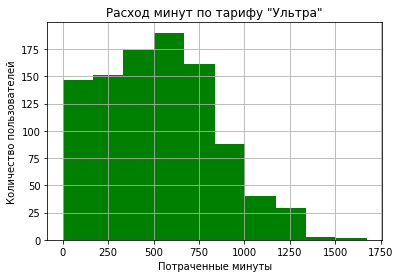

In [46]:
df.query('tariff == "ultra"').hist('minutes_used', color='green', bins=10)
plt.title('Расход минут по тарифу "Ультра"')
plt.xlabel('Потраченные минуты')
plt.ylabel('Количество пользователей')

Text(0, 0.5, 'Количество пользователей')

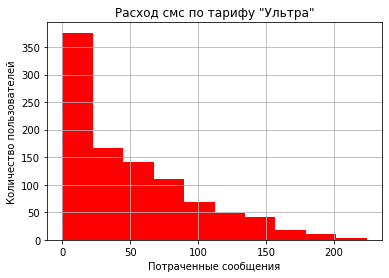

In [47]:
df.query('tariff == "ultra"').hist('messages_used', color='red', bins=10)
plt.title('Расход смс по тарифу "Ультра"')
plt.xlabel('Потраченные сообщения')
plt.ylabel('Количество пользователей')

Text(0, 0.5, 'Количество пользователей')

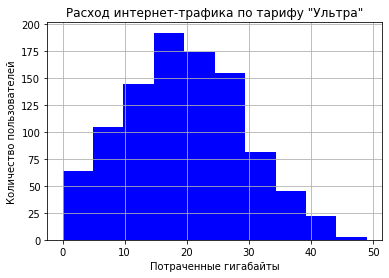

In [48]:
df.query('tariff == "ultra"').hist('gb_used', color='blue', bins=10)
plt.title('Расход интернет-трафика по тарифу "Ультра"')
plt.xlabel('Потраченные гигабайты')
plt.ylabel('Количество пользователей')

Text(0, 0.5, 'Количество пользователей')

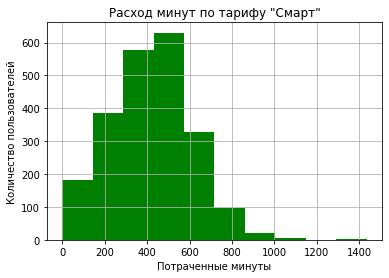

In [49]:
df.query('tariff == "smart"').hist('minutes_used', color='green', bins=10)
plt.title('Расход минут по тарифу "Смарт"')
plt.xlabel('Потраченные минуты')
plt.ylabel('Количество пользователей')

Text(0, 0.5, 'Количество пользователей')

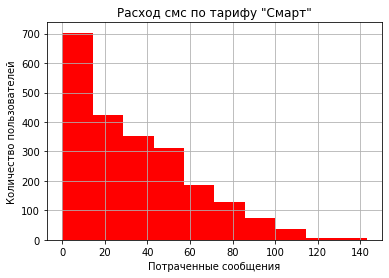

In [50]:
df.query('tariff == "smart"').hist('messages_used', color='red', bins=10)
plt.title('Расход смс по тарифу "Смарт"')
plt.xlabel('Потраченные сообщения')
plt.ylabel('Количество пользователей')

Text(0, 0.5, 'Количество пользователей')

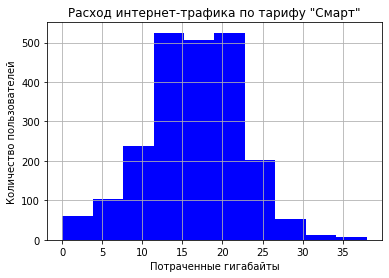

In [51]:
df.query('tariff == "smart"').hist('gb_used', color='blue', bins=10)
plt.title('Расход интернет-трафика по тарифу "Смарт"')
plt.xlabel('Потраченные гигабайты')
plt.ylabel('Количество пользователей')

Графики расхода минут и гигабайтов интеренета обладают нормальным распределением. Значительная доля абонентов либо совсем не использует смс, либо используют их по минимуму, это легко объясняется массовостью интеренет-мессенджеров, которые не идут в счет сообщений по тарифам.

Получим данные по разбросу значений для каждого вида услуг, а также месячной прибыли.

In [52]:
df.pivot_table(index='tariff', values='minutes_used', aggfunc=('mean', 'median', 'var', 'std'))

,mean,median,std,var
tariff,,,,
smart,417.934948,422.0,190.313730,36219.315784
ultra,526.623350,518.0,317.606098,100873.633397


In [53]:
df.pivot_table(index='tariff', values='messages_used', aggfunc=('mean', 'median', 'var', 'std'))

,mean,median,std,var
tariff,,,,
smart,33.384029,28.0,28.227876,796.812958
ultra,49.363452,38.0,47.804457,2285.266143


In [54]:
df.pivot_table(index='tariff', values='gb_used', aggfunc=('mean', 'median', 'var', 'std'))

,mean,median,std,var
tariff,,,,
smart,16.328848,17.0,5.747061,33.028706
ultra,19.494417,19.0,9.853511,97.091690


In [55]:
df.pivot_table(index='tariff', values='income', aggfunc=('mean', 'median', 'var', 'std'))

,mean,median,std,var
tariff,,,,
smart,1289.973531,1023.0,818.404367,669785.708006
ultra,2070.152284,1950.0,376.187114,141516.745079


Разброс значений расхода по тарифу "Ультра" выше, что в целом логично, по этому тарифу предоставляется значительно больше лимит звонков, смс и интернета.

Более интересными выглядят данные по прибыли, тариф "Смарт" в среднем приносит больше половины от прибыли тарифа "Ультра", при стоимости почти в 4 раза меньше. Также по этому показателю разброс тарифа "Смарт" в разы превышает аналогиченые показатели по тарифу "Ультра". Можно предположить, что часть пользователей генерирует сверхприбыли за счет сильного превышения лимитов установленных абонентской платой.

Проверим пару гипотез.

Сначала проверим гипотезу о равенстве средней выручки между тарифами:

Нулевая гипотеза - "Средняя выручка по тарифам "Смарт" и "Ультра" равна".

Альтернативная гипотеза - "Средняя выручка пользователей тарифов "Ультра" и "Смарт" различаются"

In [56]:
alpha = 0.05 # одно из общепринятых значений.
sample_smart = df.query('tariff == "smart"')['income'] # выборка по тарифу "Смарт"
sample_ultra = df.query('tariff == "ultra"')['income'] # выборка по тарифу "Ультра"
results = st.ttest_ind(sample_smart, sample_ultra, equal_var=False) # мы уже виделу разницу в вариациях, к тому же выборки имеют разный размер, следоватьельно необходимо выставить параметр equal_var=False
print(results.pvalue) # результаты вывожу как в тренажере, для наглядности.
if results.pvalue < alpha: 
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

4.2606313931076085e-250
Отвергаем нулевую гипотезу


Следовательно принимает альтернативную гипотезу. Выручка по тарифам различается.

Вторая гипотеза, о равенстве выручки между абонентами из Москвы и остальных городов:

Нулевая гипотеза - "Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов".

Альтернативная гипотеза - "Средняя выручка пользователей из Москвы не равна выручке пользователей из других регионов".

In [57]:
alpha = 0.01 # второе общепринятое значение
sample_moscow = df.query('city == "Москва"')['income'] # выборка по Москве
sample_regions = df.query('city != "Москва"')['income'] # выборка по остальным городам
results = st.ttest_ind(sample_moscow, sample_regions, equal_var=False) # аналагочно проверке предыдущей гипотезы, в связи с разным размером выборок, выставляем параметр equal_var=False
print(results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


Делаем вывод, что средняя выручка в Московском регионе не сильно отличается от остальных.

## Общий вывод
Предоставленная выборка абонентов достаточно репрезентативна для проведения исследования. Календарные значения требуют изменения формата.Из нескольких предоставленных датасетов был собран один, также были добавлены вычислений месячной выручки.

При исследовании установлено, что средняя выручка по тарифам различается. Тариф "Ультра" в среднем приносит больше прибыли в связи с изначально более высокой стоимостью, однако пользователи тарифа "Смарт" значительно чаще превышают лимиты установленные абонентской платой, тем самым генерируя прибыль выше ожидаемой. Абоненты из Москвы не приносят больше прибыли относительно регионов.

Тарифы сильно различаются в цене и том, как каждый из них генерирует прибыль. Скорее всего они также направлены на разную аудиторию. В случае необходимости выбора одного, чисто математически, исходя из предоставленных данных, следует сделать выбор в пользщу тарифа "Ультра". Тариф "Смарт" генерирует за счет абонентов превышающих месячные лимиты, что является более рисковым методом по сравнению с более высокой базовой ценой в тарифе "Ультра". Альтернативным вариантом, при ставке на тариф "Смарт", может быть повышение цен на услуги сверх предоставленных лимитов.